# Predicting Bikesharing rentals Per Hour using XGBoost and Sklearn Models

**Importing libraries:**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime
from scipy import stats

 **Loading the data:**

In [0]:
trainSet = pd.read_csv('train.csv')
testSet = pd.read_csv('test.csv')

In [27]:
trainSet.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


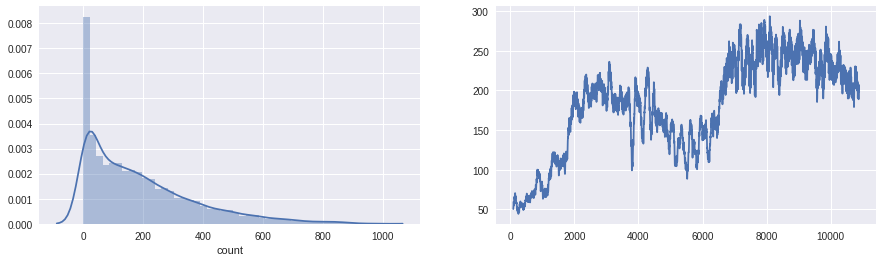

In [28]:
fig, axes = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
sn.distplot(trainSet["count"],ax=axes[0])
plt.plot(pd.rolling_mean(trainSet['count'], 100))
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


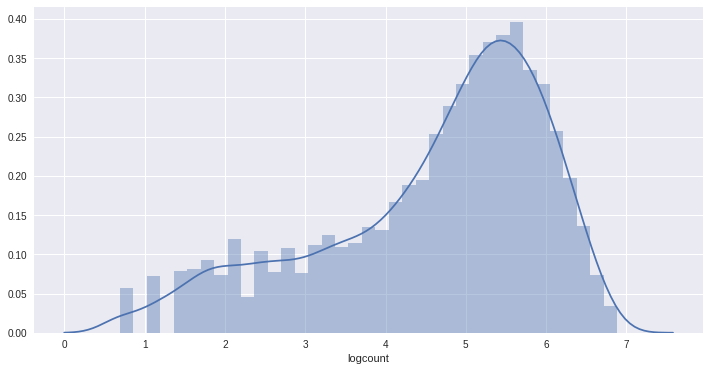

In [30]:
trainSet['logcount'] = trainSet['count'].apply(lambda x: np.log1p(x))
fig, axes = plt.subplots(figsize=(12, 6))
sn.distplot(trainSet["logcount"], ax=axes)

# Extracting: 'date', 'month', 'hour', 'weekday' from Date Time Field

In [0]:
trainSet['date'] = trainSet.datetime.apply(lambda x : x.split()[0])
trainSet['hour'] = trainSet.datetime.apply(lambda x : x.split()[1].split(":")[0])
trainSet['weekday'] = trainSet.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').weekday())
trainSet['month'] = trainSet.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').month)

testSet['date'] = testSet.datetime.apply(lambda x : x.split()[0])
testSet['hour'] = testSet.datetime.apply(lambda x : x.split()[1].split(":")[0])
testSet['weekday'] = testSet.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').weekday())
testSet['month'] = testSet.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').month)

timeColumn = testSet['datetime']

# Regressor with XGBoost

In [0]:
import xgboost as xgb

X = trainSet.drop(['count', 'datetime', 'registered', 'casual', 'date', 'logcount'], axis=1).values
Y = trainSet['logcount'].values

testX = testSet.drop(['datetime', 'date'], axis=1).values

trainMatrix = xgb.DMatrix(X, label=Y)


#Parameters:
max_depth = 5
min_child_weight = 8
subsample = 0.9
num_estimators = 1000
learning_rate = 0.1

#XGB instance:
clf = xgb.XGBRegressor(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                n_estimators=num_estimators,
                learning_rate=learning_rate)

clf.fit(X,Y)

pred = clf.predict(testX)
pred = np.expm1(pred)

#Saving predictions into a .csv file:

submission = pd.DataFrame({
        "datetime": timeColumn,
        "count": pred
    })
submission.to_csv('XGBNoFE.csv', index=False)

# Distribution of working and non-working days, seasons and daytime

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


[Text(0, 0.5, 'count'), Text(0.5, 0, 'workingday')]

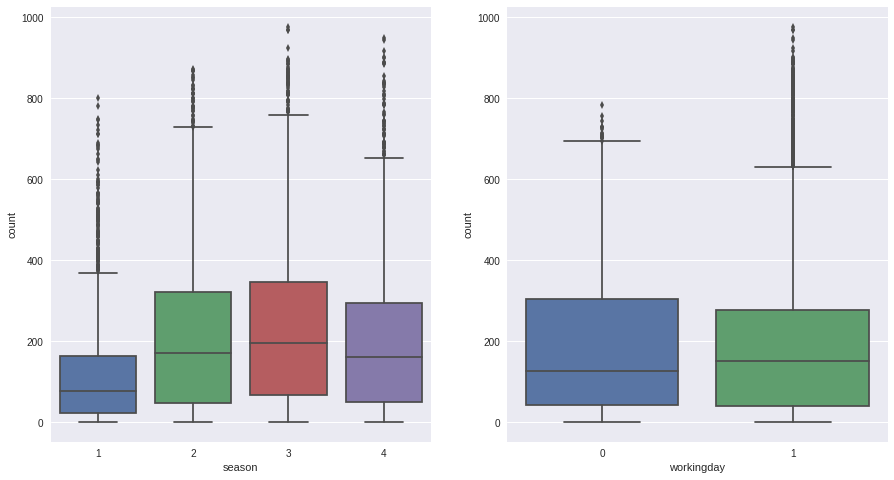

In [34]:
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(15, 8)
sn.boxplot(data=trainSet, y='count', x='season', ax=axes[0])
sn.boxplot(data=trainSet, y='count', x='workingday', ax=axes[1])
axes[0].set(xlabel='season', ylabel='count')
axes[1].set(xlabel='workingday', ylabel='count')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


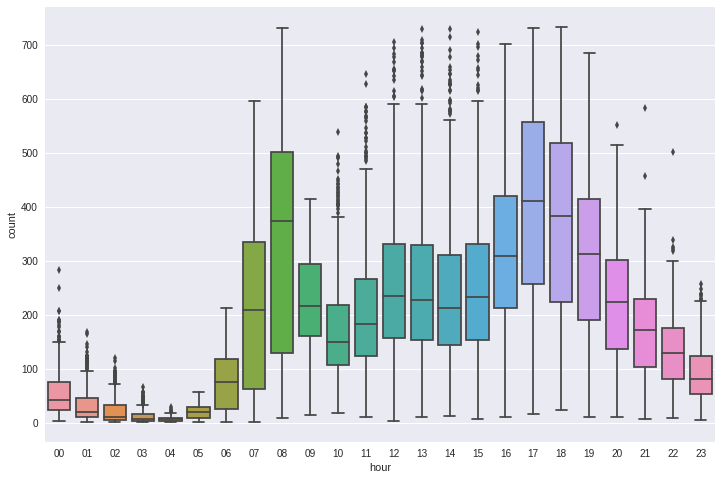

In [47]:
fix, axes = plt.subplots(figsize=(12, 8))
sn.boxplot(data=trainSet, y='count', x='hour', ax=axes)

In [37]:
trainSetWithoutOutliers = trainSet[np.abs(trainSet['count']-trainSet['count'].mean())
                                     <=(3*trainSet['count'].std())] 
print(trainSetWithoutOutliers.shape)
trainSet = trainSetWithoutOutliers

(10664, 17)


# Correlation between features

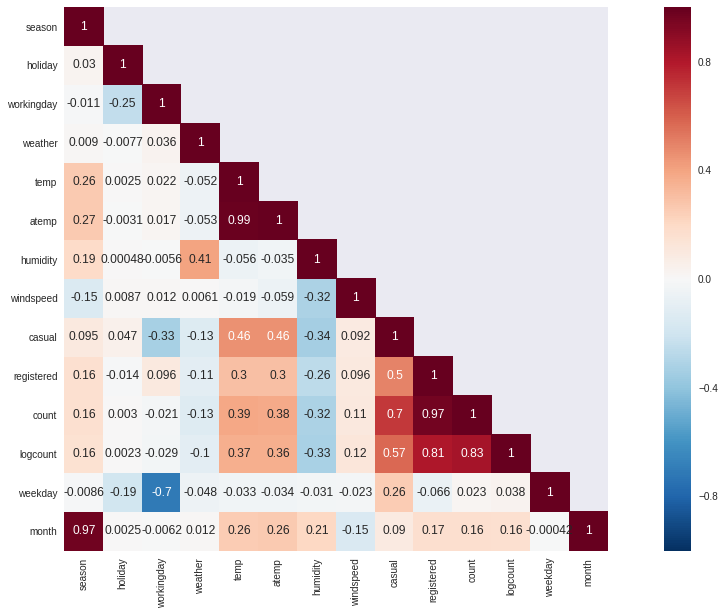

In [38]:
corrMat = trainSet.corr()
mask = np.array(corrMat)
mask[np.tril_indices_from(mask)] = False
fig, ax= plt.subplots(figsize=(20, 10))
sn.heatmap(corrMat, mask=mask,vmax=1., square=True,annot=True)

# Features engineering

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


[Text(0, 0.5, 'count'), Text(0.5, 0, 'hour')]

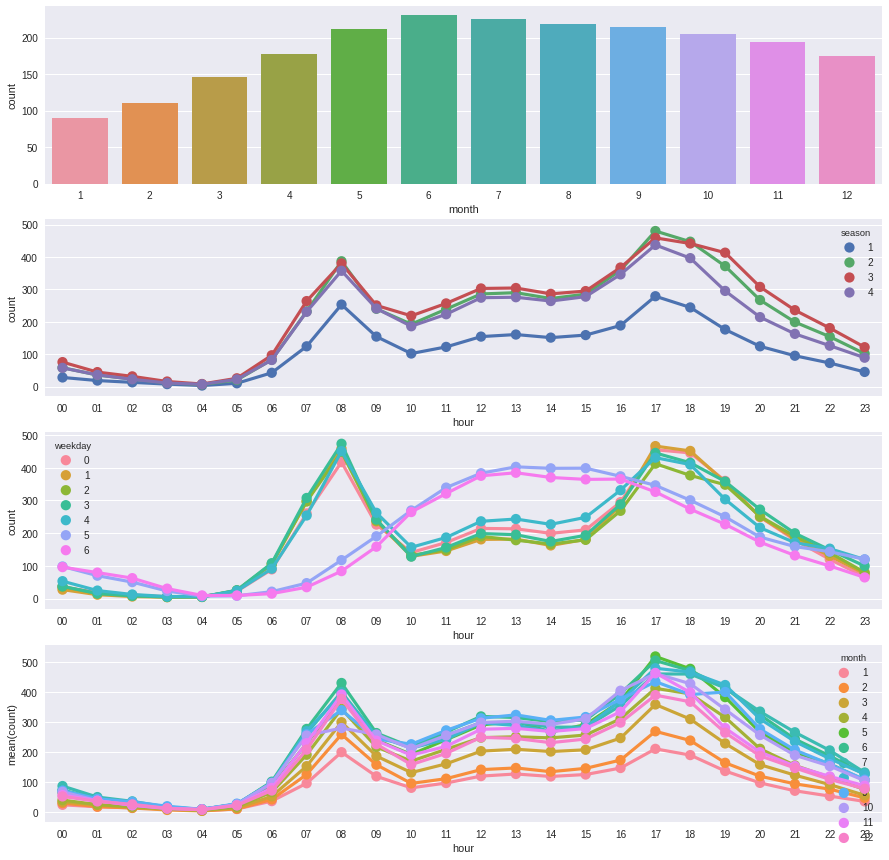

In [39]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))

meanMonthly = pd.DataFrame(trainSet.groupby('month')['count'].mean()).reset_index().sort_values(by='count', ascending=False)
sn.barplot(data=meanMonthly, x='month', y='count', ax=axes[0])
axes[0].set(xlabel='month', ylabel='count')

hoursSeasonly = pd.DataFrame(trainSet.groupby(['hour', 'season'], sort=True)['count'].mean()).reset_index()
sn.pointplot(x=hoursSeasonly['hour'], y=hoursSeasonly['count'], hue=hoursSeasonly['season'], data=hoursSeasonly, join=True, ax=axes[1])
axes[1].set(xlabel='hour', ylabel='count')

hoursDayly = pd.DataFrame(trainSet.groupby(['hour','weekday'], sort=True)['count'].mean()).reset_index()
sn.pointplot(x=hoursDayly['hour'], y=hoursDayly['count'], hue=hoursDayly['weekday'], data=hoursDayly, join=True,ax=axes[2])
axes[2].set(xlabel='hour', ylabel='count')

hoursSeasonly = pd.DataFrame(trainSet.groupby(['hour', 'month'], sort=True)['count'].mean()).reset_index()
sn.pointplot(x=hoursSeasonly['hour'], y=hoursSeasonly['count'], hue=hoursSeasonly['month'], data=hoursSeasonly, join=True, ax=axes[3])
axes[1].set(xlabel='hour', ylabel='count')

# Features selected for training part

In [42]:
X = trainSet.drop(['date', 'temp', 'casual', 'registered', 'logcount', 'datetime', 'count'], axis=1)

season_df = pd.get_dummies(trainSet['season'], prefix='s', drop_first=True)
weather_df = pd.get_dummies(trainSet['weather'], prefix='w', drop_first=True)
hour_df = pd.get_dummies(trainSet['hour'], prefix='h', drop_first=True)
weekday_df = pd.get_dummies(trainSet['weekday'], prefix='d', drop_first=True)
month_df = pd.get_dummies(trainSet['month'], prefix='m', drop_first=True)

X = X.join(season_df)
X = X.join(weather_df)
X = X.join(hour_df)
X = X.join(weekday_df)
X = X.join(month_df)

X = X.values
Y=trainSet['logcount'].values
print(X.shape)

testX = testSet.drop(['date', 'temp', 'datetime'], axis=1)

season_df = pd.get_dummies(testSet['season'], prefix='s', drop_first=True)
weather_df = pd.get_dummies(testSet['weather'], prefix='w', drop_first=True)
hour_df = pd.get_dummies(testSet['hour'], prefix='h', drop_first=True)
weekday_df = pd.get_dummies(testSet['weekday'], prefix='d', drop_first=True)
month_df = pd.get_dummies(testSet['month'], prefix='m', drop_first=True)

testX = testX.join(season_df)
testX = testX.join(weather_df)
testX = testX.join(hour_df)
testX = testX.join(weekday_df)
testX = testX.join(month_df)

testX = testX.values
print(testX.shape)

(10739, 56)
(6493, 56)


# Training the model

In [0]:
clf=xgb.XGBRegressor(max_depth=8,min_child_weight=6,gamma=0.4,colsample_bytree=0.6,subsample=0.6)
clf.fit(X,Y)

pred = clf.predict(testX)
pred = np.expm1(pred)

submission = pd.DataFrame({
        "datetime": timeColumn,
        "count": pred
    })
submission.to_csv('XGBwithFE.csv', index=False)

# Training models using sklearn

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

In [0]:
def loss_func(truth, prediction):
    truth = np.expm1(truth)
    prediction = np.expm1(prediction)
    log1 = np.array([np.log(x + 1) for x in truth])
    log2 = np.array([np.log(x + 1) for x in prediction])
    return np.sqrt(np.mean((log1 - log2)**2))

# Random Forest model

In [52]:
param_grid = {
    'n_estimators': [50, 80, 100, 120],
    'max_depth': [None, 1, 2, 5],
    'max_features': ['sqrt', 'log2', 'auto']
}

scorer = make_scorer(loss_func, greater_is_better=False)

regr = RandomForestRegressor(random_state=42)

rfr = GridSearchCV(regr, param_grid, cv=4, scoring=scorer, n_jobs=4).fit(X, Y)
print('\tParams:', rfr.best_params_)
print('\tScore:', rfr.best_score_)

	Params: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 80}
	Score: -0.5926824873634983


In [0]:
pred = rfr.predict(testX)
pred = np.expm1(pred)

submission = pd.DataFrame({
        "datetime": timeColumn,
        "count": pred
    })
submission.to_csv('RandomForest.csv', index=False)

# Gradient Boosting Regressor model

In [49]:

gbr = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.01, max_depth=4)

gbr.fit(X, Y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=2000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
pred = gbr.predict(testX)
pred = np.expm1(pred)

submission = pd.DataFrame({
        "datetime": timeColumn,
        "count": pred
    })
submission.to_csv('GradientBoost.csv', index=False)